In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import sys
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from tqdm import tqdm 

sys.path.append('../src')
from UNet2D import UNet2D
from datasets import MycetomaDataset
from metrics import batch_dice_coeff, bce_dice_loss, dice_coefficient

In [2]:
DATA_DIR = '../data'

In [3]:
# Get full image path by adding filename to base path

# Get the paths
train_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*.jpg')])
val_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*.jpg')])

print(f"Train length: {len(train_paths)}")
print(f"Val length: {len(val_paths)}")

Train length: 537
Val length: 87


In [4]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
train_dataset = MycetomaDataset(train_paths, DATA_DIR)
val_dataset = MycetomaDataset(val_paths, DATA_DIR)

In [6]:
im,mask = train_dataset[0]

/Users/olivermills/CDT_no_icloud/Challenges/Mycetoma/notebooks/../src/datasets.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  mask = torch.from_numpy(mask).float().unsqueeze(0)


In [7]:
im.shape

torch.Size([3, 600, 800])

In [8]:
train_dataset.__len__()

537

In [9]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [10]:
batch = next(iter(train_loader))

In [11]:
im, mask = batch

In [12]:
mask.shape

torch.Size([16, 1, 600, 800])

In [13]:
# Plot an image, along with prediction and ground truth
def plot_image(im, pred, gt):

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    ax[0].imshow(im)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(pred)
    ax[1].set_title('prediction')
    ax[1].axis('off')

    ax[2].imshow(gt)
    ax[2].set_title('GT')
    ax[2].axis('off')

    plt.show()

In [14]:
model = UNet2D(3, 1, 8)
model = model.to(device)

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [16]:
train_dice_scores = []
val_dice_scores = []
train_losses = []
val_losses = []

  3%|▎         | 1/34 [00:46<25:40, 46.68s/it]

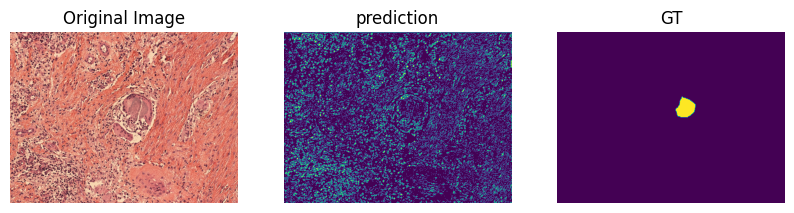

  6%|▌         | 2/34 [01:30<23:58, 44.95s/it]

Dice score: 0.007706236094236374


 74%|███████▎  | 25/34 [17:54<06:35, 43.91s/it]

In [17]:
# TRAIN
from tqdm import tqdm

num_epochs = 20
threshold = 0.5
best_val_loss = np.inf

# Specify optimiser and criterion
criterion = bce_dice_loss
l_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=l_rate)

for epoch in range(num_epochs):

    # train mode
    model.train()
    running_loss = 0.0
    dice_coeff = 0.0
    n = 0    # counter for num of batches

    # Loop through train loader
    for idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)

        targets = targets.to(device)

        optimizer.zero_grad()

        # Forward, backward, and update params
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.detach().cpu().numpy()
        dice_coeff += batch_dice_coeff(outputs>threshold, targets).detach().cpu().numpy()
        n += 1

        # show slice of first train object
        if idx == 1:
            im = inputs[0].detach().cpu().permute(1,2,0).numpy()
            pred = (outputs[0][0].detach().cpu().numpy()>threshold).astype(int)
            gt = targets[0][0].detach().cpu().numpy()

            plot_image(im, pred, gt)
            print(f"Dice score: {dice_coefficient(torch.from_numpy(pred).float(), torch.from_numpy(gt).float())}")
    # Get train metrics, averaged over number of images in batch
    train_loss = running_loss/n
    train_dice_av = dice_coeff/n

    # After each batch, loop through validation loader and get metrics
    # set model to eval mode and reset metrics
    model.eval()
    running_loss = 0.0
    dice_coeff = 0.0
    n = 0

    print("------------ VALIDATION -------------")

    # Perform loop without computing gradients
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.detach().cpu().numpy()
            dice_coeff += batch_dice_coeff(outputs>threshold, targets).detach().cpu().numpy()
            n += 1

            # show slice of first val object every 5 batches
            if idx % 5 == 0:
                im = inputs[0].detach().cpu().permute(1,2,0).numpy()
                pred = (outputs[0][0].detach().cpu().numpy()>threshold).astype(int)
                gt = targets[0][0].detach().cpu().numpy()

                plot_image(im, pred, gt)
                print(f"Dice score: {dice_coefficient(torch.from_numpy(pred).float(), torch.from_numpy(gt).float())}")

    # Val metrics
    val_loss = running_loss/n
    val_dice_av = dice_coeff/n

    # print stats
    print(f"--------- EPOCH {epoch} ---------")
    print(f"Train Loss: {train_loss}, Train Dice Score: {train_dice_av}")
    print(f"Val Loss: {val_loss}, Val Dice Score: {val_dice_av}")

    # save stats
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dice_scores.append(train_dice_av)
    val_dice_scores.append(val_dice_av)

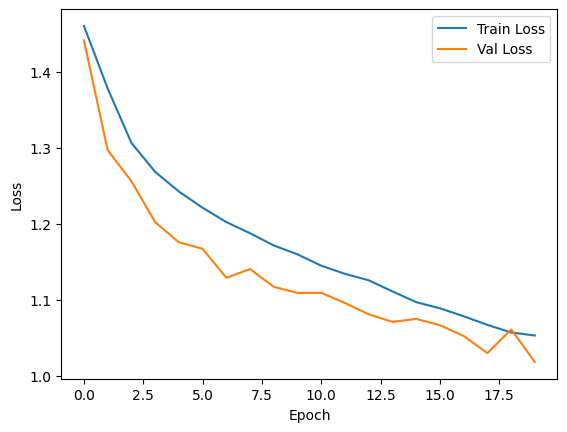

In [41]:
# Plot loss statistics
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

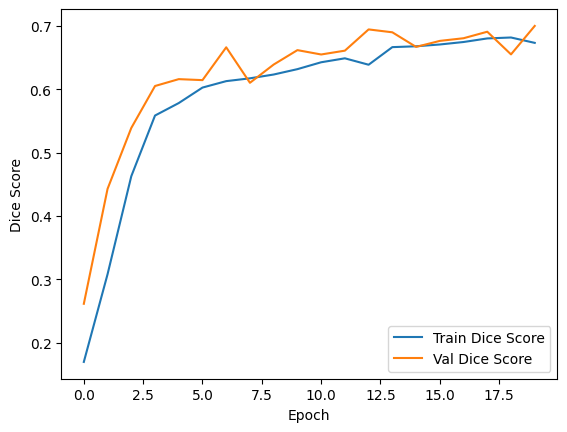

In [42]:
# Plot Dice Scores
plt.plot(train_dice_scores, label='Train Dice Score')
plt.plot(val_dice_scores, label='Val Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

In [ ]:
# save my model

In [ ]:
# Try opening two image and corresponding mask

path = 'BM37_3'

print(f"Image path: {train_paths[idx]}.jpg")

image_path = f"{train_paths[idx]}.jpg"
mask_path = f"{train_paths[idx]}_mask.tif"

# Load the image and mask
img = np.asarray(Image.open(image_path))
mask = np.asarray(Image.open(mask_path))

In [13]:
for i, path in enumerate(train_paths):
  if 'BM37' in path:
    print(f'{i}: {path}')

79: data/mycetoma_train/BM/BM37_2
131: data/mycetoma_train/BM/BM37_6
166: data/mycetoma_train/BM/BM37_5
178: data/mycetoma_train/BM/BM37_3
181: data/mycetoma_train/BM/BM37_1
199: data/mycetoma_train/BM/BM37_4


In [14]:
# Try opening an image and corresponding mask

idx = 178

print(f"Image path: {train_paths[idx]}.jpg")

image_path = f"{train_paths[idx]}.jpg"
mask_path = f"{train_paths[idx]}_mask.tif"

# Load the image and mask
img1 = np.asarray(Image.open(image_path))
mask1 = np.asarray(Image.open(mask_path))

Image path: data/mycetoma_train/BM/BM37_3.jpg


In [15]:
# Try opening an image and corresponding mask

idx = 199

print(f"Image path: {train_paths[idx]}.jpg")

image_path = f"{train_paths[idx]}.jpg"
mask_path = f"{train_paths[idx]}_mask.tif"

# Load the image and mask
img2 = np.asarray(Image.open(image_path))
mask2 = np.asarray(Image.open(mask_path))

Image path: data/mycetoma_train/BM/BM37_4.jpg


In [19]:
(img1==img2).all()

True

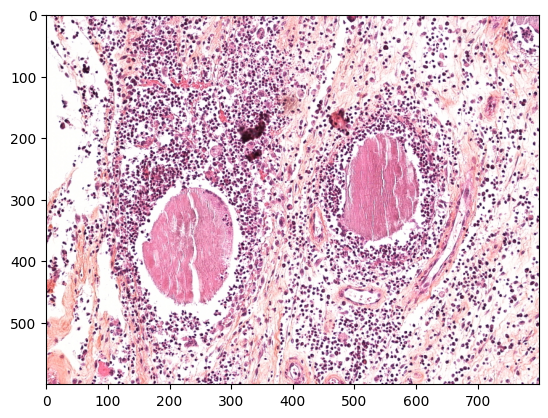

In [16]:
plt.imshow(img1)
plt.show()

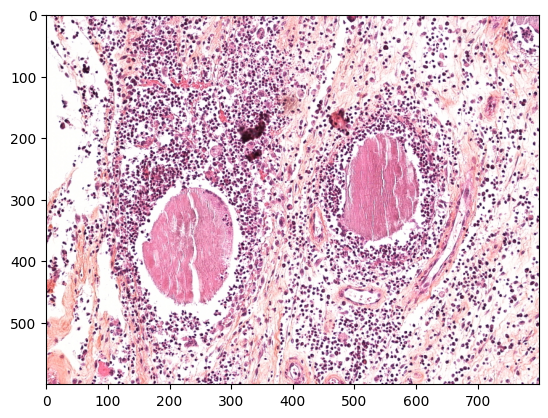

In [17]:
plt.imshow(img2)
plt.show()

In [20]:
new_mask = mask1+mask2

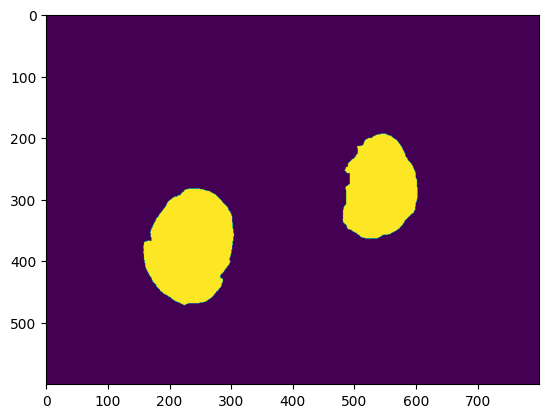

In [21]:
plt.imshow(new_mask)

In [47]:
for image, mask in val_dataset:
    fig, ax = plt.subplots(1, 2)

    ax[0].imshow(image.permute(1,2,0).numpy())
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(mask.squeeze().numpy())
    ax[1].set_title('GT')
    ax[1].axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.